# NLP - Natural Language Processing

In [214]:
#Get the notebook from 
#!git clone https://github.com/maniceet/imdb-sentiment-analysis

<img src = "https://imgs.xkcd.com/comics/regular_expressions.png"> </img>

**Understanding Language is a very complex thing -- but something the we humans are amazingly good at**

The question beckons that how can a computer understands language?

## Objective
What we want you to take away from this session
* 1. What does one mean by NLP?
* 2. Where can one use this?
* 3. Where do I start?

In [79]:
import os
os.getcwd()

'/home/fractaluser/NLP Idea Session/NLP Idea Session'

In [80]:
#Loading libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## IMDB dataset and the sentiment classification task

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.
You can get the dataset in the raw form from the [site](http://ai.stanford.edu/~amaas/data/sentiment/), but we will load them directly from the csv already prepped.
You are welcome to uncomment and run the block below to get the csv from the raw file, but do note that it will take some time to process

In [81]:
# %load IMDBpreprocess.py

#### Loading Training and validation Data

In [82]:
train = pd.read_csv('IMDB_train.csv')
val = pd.read_csv('IMDB_val.csv')

In [83]:
# summarize size
print("Training data: ")
print(train.shape)
print("Validation data: ")
print(val.shape)

Training data: 
(25000, 2)
Validation data: 
(25000, 2)


In [86]:
#Take a look at training set
train.head()

,Reviews,Sentiment
0,"The clichéd Polynesian males drink, fight and ...",0
1,"My comments may be a bit of a spoiler, for wha...",0
2,"Sadly,this is not 'the best British gore film ...",0
3,I turn on 700 Club once in awhile and only agr...,0
4,This was one of the worst films I have ever se...,0


In [87]:
#How many Positive and Negative Reviews we have
print(f'We have {train.Sentiment.value_counts()[0]} positive reviews in our training set and {train.Sentiment.value_counts()[1]} negative reviews in our training set')

We have 12500 positive reviews in our training set and 12500 negative reviews in our training set


In [88]:
#Prepping the Data
y_train = train.Sentiment
X_train = train.drop(['Sentiment'], axis = 1)
y_val = val.Sentiment
X_val = val.drop(['Sentiment'], axis = 1)

In [89]:
# Summarize number of classes
print("Classes: ")
print(np.unique(y_train))

Classes: 
[0 1]


Review length: 
Mean 1325.07 words (median - 979.000000)


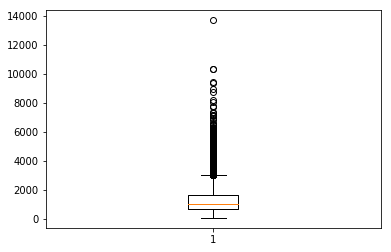

In [92]:
# Summarize review length
print("Review length: ")
result = [len(review) for review in X_train.Reviews]
print("Mean %.2f words (median - %f)" % (np.mean(result), np.median(result)))
# plot review length
plt.boxplot(result)
plt.show()

### Cleaning the Data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* 1. Remove HTML Tags
* 2. Remove accented charaters
* 3. Expand Contractions
* 4. Make text all lower case, Remove punctuation, Remove numerical values
* 5. Spelling Correction*
* 6. Stemming / lemmatization
* 7. Tokenize and Remove stop words

**More data cleaning steps after tokenization:**
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

In [106]:
#Taking a look at one of the reviews
X_train.Reviews[1999]

"This film is exactly what you get when you really over stretch your abilities, it's like someone who has just passed there driving test and then pitting them in a formula 1 Grand Prix (not I might add, the US Grand Prix as everyone might pull out due to dodgy tyres and you might just win), that is how far short this film falls. Now don't take this the wrong way, I love B-Movies, around half my collection is made of B-Movies but I don't think there are enough letters in the alphabet to describe how bad this film is.<br /><br />First of the story (for a B-Movie) isn't that bad, it has potential there to make a B-Movie brand, were not talking Friday 13th potential, but potential none the less. But what really lets this film down is the acting, at not one second do I believe anything, it's like watching QVC except the presenters on QVC tend to have a heavier tan.<br /><br />In summary I'd like to say I've seen worse films, but I can't."

### <font color='red'>1. Removing HTML Tags</font>
Text often contains html tags, and it is important to remove them first as they donot add any value to our analysis

In [122]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
r_html = lambda x: strip_html_tags(x)

In [123]:
X_train_cleaned = pd.DataFrame(X_train.Reviews.apply(r_html))
X_val_cleaned = pd.DataFrame(X_val.Reviews.apply(r_html))

In [124]:
X_train_cleaned.Reviews[1999]

"This film is exactly what you get when you really over stretch your abilities, it's like someone who has just passed there driving test and then pitting them in a formula 1 Grand Prix (not I might add, the US Grand Prix as everyone might pull out due to dodgy tyres and you might just win), that is how far short this film falls. Now don't take this the wrong way, I love B-Movies, around half my collection is made of B-Movies but I don't think there are enough letters in the alphabet to describe how bad this film is.First of the story (for a B-Movie) isn't that bad, it has potential there to make a B-Movie brand, were not talking Friday 13th potential, but potential none the less. But what really lets this film down is the acting, at not one second do I believe anything, it's like watching QVC except the presenters on QVC tend to have a heavier tan.In summary I'd like to say I've seen worse films, but I can't."

### <font color = 'red'> 2. Removing accented characters</font>
Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e.

In [125]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

r_accented = lambda x: remove_accented_chars(x)

In [126]:
X_train_cleaned = pd.DataFrame(X_train_cleaned.Reviews.apply(r_accented))
X_val_cleaned = pd.DataFrame(X_val_cleaned.Reviews.apply(r_accented))

In [127]:
remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

### <font color = 'red'>3. Expanding Contractions </font>
Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.
[Source](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py)

In [113]:
#Uncomment the below line and run to get the code for contractions
# %load contraction.py

In [114]:
from contraction import expand_contractions
expand = lambda x: expand_contractions(x)

In [115]:
X_train_cleaned = pd.DataFrame(X_train_cleaned.Reviews.apply(expand))
X_val_cleaned = pd.DataFrame(X_val_cleaned.Reviews.apply(expand))

In [116]:
X_train_cleaned.Reviews[1999]

'This film is exactly what you get when you really over stretch your abilities, it is like someone who has just passed there driving test and then pitting them in a formula 1 Grand Prix (not I might add, the US Grand Prix as everyone might pull out due to dodgy tyres and you might just win), that is how far short this film falls. Now do not take this the wrong way, I love B-Movies, around half my collection is made of B-Movies but I do not think there are enough letters in the alphabet to describe how bad this film is.First of the story (for a B-Movie) is not that bad, it has potential there to make a B-Movie brand, were not talking Friday 13th potential, but potential none the less. But what really lets this film down is the acting, at not one second do I believe anything, it is like watching QVC except the presenters on QVC tend to have a heavier tan.In summary I would like to say I have seen worse films, but I cannot.'

### <font color = 'red'> 4. Make text all lower case, Remove punctuation, Remove numerical values</font>

In [128]:
def remove_special_characters(text, remove_digits=False):
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text) #Removing words that have numbers in them
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[''""..._]' #Removing punctuations and underscores
    text = re.sub(pattern, '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)   #Removing characters that appear more than twice
    return text
r_special = lambda x: remove_special_characters(x, remove_digits = True)

In [129]:
X_train_cleaned = pd.DataFrame(X_train_cleaned.Reviews.apply(r_special))
X_val_cleaned = pd.DataFrame(X_val_cleaned.Reviews.apply(r_special))

In [130]:
X_train_cleaned.Reviews[1999]

'this film is exactly what you get when you really over stretch your abilities its like someone who has just passed there driving test and then pitting them in a formula  grand prix not i might add the us grand prix as everyone might pull out due to dodgy tyres and you might just win that is how far short this film falls now dont take this the wrong way i love bmovies around half my collection is made of bmovies but i dont think there are enough letters in the alphabet to describe how bad this film isfirst of the story for a bmovie isnt that bad it has potential there to make a bmovie brand were not talking friday  potential but potential none the less but what really lets this film down is the acting at not one second do i believe anything its like watching qvc except the presenters on qvc tend to have a heavier tanin summary id like to say ive seen worse films but i cant'

###  <font color = 'red'> 5. Spelling Corrections* </font>
We’ve all seen articles/texts/tweets with a plethora of spelling mistakes. 

In that regard, spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words. For example, “Analytics” and “analytcs” will be treated as different words even if they are used in the same sense.
We are not going through spelling corrections now due to time constraints, but you can feel free to run the block of code below on your own

In [140]:
'''
from textblob import TextBlob
def correct_spelling(text):
    blob = TextBlob(text)
    text = str(blob.correct())
    return text
spell_check = lambda x: correct_spelling(x)

correct_spelling('It doent wrks perfctly evryt')
'''

"\nfrom textblob import TextBlob\ndef correct_spelling(text):\n    blob = TextBlob(text)\n    text = str(blob.correct())\n    return text\nspell_check = lambda x: correct_spelling(x)\n\ncorrect_spelling('It doent wrks perfctly evryt')\n"

In [141]:
#X_train_cleaned = pd.DataFrame(X_train_cleaned.Reviews.apply(spell_check))
#X_val_cleaned = pd.DataFrame(X_val_cleaned.Reviews.apply(spell_check))

### <font color = 'red'> 6.1 Stemming </font>
Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. Consider the word JUMP. You can add affixes to it and form new words like JUMPS, JUMPED, and JUMPING. In this case, the base word JUMP is the word stem.
But Stemming has it's disadvantages as you will see in the same example below, it sometimes fails to find the stem of the word correctly.

In [150]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [143]:
print(simple_stemmer('My amazing system that keeps crashing daily just crashed again'))


My amaz system that keep crash daili just crash again


### <font color = 'red'> 6.2 Lemmatization </font>
Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using **nltk** here.<br>

<i>Do note that the lemmatization process is considerably slower than stemming, because an additional step is involved where the root form or lemma is formed by removing the affix from the word if and only if the lemma is present in the dictionary.</i>

**NOTE: If you don't have time then go for stemming else lemmatization is the better option**

In [144]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/fractaluser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [145]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    text = ' '.join([lemmatizer.lemmatize(word, pos = 'a') for word in text.split()])
    return text

lemma = lambda x: lemmatize_text(x)

In [146]:
print(lemmatize_text('My amazing system that keeps crashing daily just crashed again'))


My amaze system that keep crash daily just crash again


In [147]:
X_train_cleaned = pd.DataFrame(X_train_cleaned.Reviews.apply(lemma))
X_val_cleaned = pd.DataFrame(X_val_cleaned.Reviews.apply(lemma))

In [148]:
X_train_cleaned.Reviews[1999]

'this film be exactly what you get when you really over stretch your abilities its like someone who have just pass there drive test and then pit them in a formula grand prix not i might add the us grand prix as everyone might pull out due to dodgy tyres and you might just win that be how far short this film fall now dont take this the wrong way i love bmovies around half my collection be make of bmovies but i dont think there be enough letter in the alphabet to describe how bad this film isfirst of the story for a bmovie isnt that bad it have potential there to make a bmovie brand be not talk friday potential but potential none the less but what really let this film down be the act at not one second do i believe anything its like watch qvc except the presenters on qvc tend to have a heavy tanin summary id like to say ive see bad film but i cant'

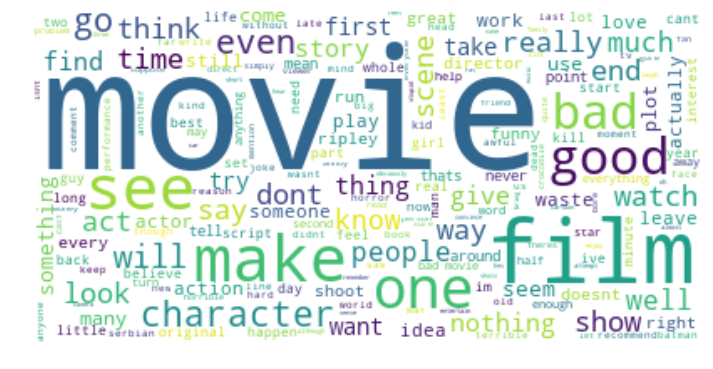

In [149]:
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(no_reviews = 50, title = None):
    wordcloud_text = ''.join([review for review in X_train_cleaned.Reviews[:no_reviews]])
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color='white',
                          max_words=200,
                          max_font_size=100,                          
                          stopwords = STOPWORDS # set or space-separated string
                          ).generate(wordcloud_text)
    
    fig = plt.figure(1, figsize=(12,18))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        
        
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generate_wordcloud(no_reviews = 100)

<img src = "https://imgs.xkcd.com/comics/fixing_problems.png"></img>

## Creating our Matrix also know as Document Term Matrix (DTM)

For many of the techniques we'll be using further, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.
Addition stopwords can also be used

In [173]:
with open('stopwords.en.txt', 'r') as f:
    additional_stop_words = f.read().splitlines()


In [174]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

#Loading stopwords
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

#Building bow DTM
cv = CountVectorizer(stop_words= stop_words, ngram_range=(1,2), max_features = 1000000)

In [175]:
X_train_bow = cv.fit_transform(X_train_cleaned.Reviews)
#You donot want to fit_transform on your validation set
X_val_bow = cv.transform(X_val_cleaned.Reviews)
print("BOW Matrix Ready")

BOW Matrix Ready


In [176]:
X_train_bow.shape

(25000, 1000000)

In [178]:
vocab = cv.get_feature_names(); vocab[40000:40010]

['character pull',
 'character punch',
 'character pure',
 'character purpose',
 'character push',
 'character quality',
 'character quentin',
 'character quest',
 'character question',
 'character quick']

In [179]:
data_dtm = pd.DataFrame(X_train_bow[:200].toarray(), columns=cv.get_feature_names())

In [180]:
data_dtm.iloc[:,:20].head()

,aachen,aag,aag bad,aage,aage haugland,aah,aahh,aaker,aames,aames cruise,aamir,aamir khan,aand,aankhen,aapke,aapke hain,aapkey,aapkey hain,aardman,aardman animation
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [207]:
#Building TFIDF DTM
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1, ngram_range=(1,2),
                     sublinear_tf=True, stop_words = stop_words, max_features = 1000000)

X_train_tf = tv.fit_transform(X_train_cleaned.Reviews)
X_val_tf = tv.transform(X_val_cleaned.Reviews)

In [208]:
X_train_tf

<25000x1000000 sparse matrix of type '<class 'numpy.float64'>'
	with 3786316 stored elements in Compressed Sparse Row format>

In [209]:
data_dtm_tf = pd.DataFrame(X_train_tf[:200].toarray(), columns=cv.get_feature_names())

In [210]:
data_dtm_tf.iloc[:,:20].head()

,aachen,aag,aag bad,aage,aage haugland,aah,aahh,aaker,aames,aames cruise,aamir,aamir khan,aand,aankhen,aapke,aapke hain,aapkey,aapkey hain,aardman,aardman animation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Training, Prediction and Performance Evaluation
<img src = "https://www.explainxkcd.com/wiki/images/d/d3/machine_learning.png"></img>

In [211]:
def model_metrics(y_true, y_pred):
    from sklearn.metrics import accuracy_score, f1_score
    accuracy = accuracy_score(y_true, y_pred)
    f1_score = f1_score(y_true, y_pred, average = 'binary')
    print(f'The model had an accuracy of {accuracy}  and a f1_score of {f1_score}')
    return None


### Naive Bayes

In [212]:
from sklearn.naive_bayes import MultinomialNB
print("For Bag of Words Model")

clf_nb = MultinomialNB(alpha = 1)
clf_nb.fit(X_train_bow, y_train)
preds_nb = clf_nb.predict(X_val_bow)
model_metrics(y_val, preds_nb)

print("For TFIDF Model")

clf_nb.fit(X_train_tf, y_train)
preds_nb = clf_nb.predict(X_val_tf)
model_metrics(y_val, preds_nb)
#Bold the output of accuracy and f1score

For Bag of Words Model
The model had an accuracy of 0.8418  and a f1_score of 0.8358853064442509
For TFIDF Model
The model had an accuracy of 0.8542  and a f1_score of 0.8509872858836515


### Logistic Regression

In [215]:
clf_log = LogisticRegression(C=1e8, dual=True)

print("For Bag of Words Model")

clf_log.fit(X_train_bow, y_train)
preds_log = clf_log.predict(X_val_bow)
model_metrics(y_val, preds_log)

print("For TFIDF Model")

clf_log.fit(X_train_tf, y_train)
preds_log = clf_log.predict(X_val_tf)
model_metrics(y_val, preds_log)

For Bag of Words Model


/home/fractaluser/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fractaluser/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The model had an accuracy of 0.86932  and a f1_score of 0.8688952205144669
For TFIDF Model
The model had an accuracy of 0.88304  and a f1_score of 0.8825797124728938


### Stochastic Gradient Descent Classifier

In [190]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(max_iter = 1000)
print("For Bag of Words Model")
clf_SGD.fit(X_train_bow, y_train)
preds_SGD = clf_SGD.predict(X_val_bow)
model_metrics(y_val, preds_SGD)

print("For TFIDF Model")

clf_SGD.fit(X_train_tf, y_train)
preds_SGD = clf_SGD.predict(X_val_tf)
model_metrics(y_val, preds_SGD)

For Bag of Words Model
The model had an accuracy of 0.86716  and a f1_score of 0.8666104349921677
For TFIDF Model
The model had an accuracy of 0.88216  and a f1_score of 0.8832990017429884


In [217]:
'''
from sklearn.feature_selection import SelectPercentile, chi2
selector = SelectPercentile(chi2, percentile=30)
selector.fit_transform(X_train_tf, y_train)
X_train_transformed = selector.transform(X_train_tf)
X_val_transformed = selector.transform(X_val_tf)

print(X_train_transformed.shape)

clf_log = LogisticRegression(C=1e8, dual=True)

print("For feature selected TFIDF Model")

clf_log.fit(X_train_transformed, y_train)
preds_log = clf_log.predict(X_val_transformed)
model_metrics(y_val, preds_log)
'''

'\nfrom sklearn.feature_selection import SelectPercentile, chi2\nselector = SelectPercentile(chi2, percentile=30)\nselector.fit_transform(X_train_tf, y_train)\nX_train_transformed = selector.transform(X_train_tf)\nX_val_transformed = selector.transform(X_val_tf)\n\nprint(X_train_transformed.shape)\n\nclf_log = LogisticRegression(C=1e8, dual=True)\n\nprint("For feature selected TFIDF Model")\n\nclf_log.fit(X_train_transformed, y_train)\npreds_log = clf_log.predict(X_val_transformed)\nmodel_metrics(y_val, preds_log)\n'

**We can see that with good data processing even simple models can outperform complex models**<br>
For further reading on NLP and using NLP with Deep Learning you can visit [this link](http://web.stanford.edu/class/cs224n/)

And finally...
<img src = "https://imgs.xkcd.com/comics/will_it_work.png"></img>